# Εργαστηριακή Άσκηση 3: Βαθιά Μάθηση

## Νευρωνικά Δίκτυα και Ευφυή Υπολογιστικά Συστήματα

| Team 10                              |          |
|--------------------------------------|----------|
| Ανδρεάς Χρυσοβαλάντης - Κωνσταντίνος | 03118102 |
| Μανίατης Ανδρέας                     | 03118070 |
| Παπανικολάου Ιωάννης                 | 03118064 |

##### Copyright 2018 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, your goal is to generate a
caption such as "a surfer riding on a wave".

<table style="text-align: center;">
<tr>
  <td>
   <img src="https://tensorflow.org/images/surf.jpg"/>
  </td>
</tr>
<tr>
  <th>A man surfing, from <a href=https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg>wikimedia</a></th>
</tr>
</table>

The model architecture used here is inspired by [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044), but has been updated to use a 2-layer Transformer-decoder. To get the most out of this tutorial you should have some experience with [text generation](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq models & attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention), or [transformers](https://www.tensorflow.org/text/tutorials/transformer).

The model architecture built in this tutorial is shown below. Features are extracted from the image, and passed to the cross-attention layers of the Transformer-decoder.

<table>
<tr>
  <th>The model architecture</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png"/>
  </td>
</tr>
</table>

The transformer decoder is mainly built from attention layers. It uses self-attention to process the sequence being generated, and it uses cross-attention to attend to the image.

By inspecting the attention weights of the cross attention layers you will see what parts of the image the model is looking at as it generates words.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

This notebook is an end-to-end example. When you run the notebook, it downloads a dataset, extracts and caches the image features, and trains a decoder model. It then uses the model to generate captions on new images.

**Αν και αρχίσαμε από το παραπάνω notebook χρησιμοποιώντας τον conventional μηχανισμό attention στη συνέχεια επιλέξαμε να συνεχίσουμε με τον Bahdanau Attention Mechanism. Ο συγκεκριμένος μηχανισμός θεωρείται σημαντική βελτίωση και επιδεικνύει καλύτερο performance ακόμα και με μεγάλα captions (αν και στην περίπτωσή μας ήδη από την προεπεξεργασία τα μειώσαμε σε μήκος). Για αυτόν τον λόγο και λόγω του περιορισμένου χρόνου και υπολογιστικής ισχύς επιλέξαμε να ξεκινήσουμε με ένα καλύτερο baseline μοντέλο.**

### The model architecture
<tr>
  <td>
   <img width=400 src="https://machinelearningmastery.com/wp-content/uploads/2021/09/bahdanau_1.png"/>
  </td>
</tr>
</table>

## Setup

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 17 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 5s (84.6 MB/s)
(Reading database ... 128208 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128175 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.7

In [2]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Successfully uninstalled tensorflow-2.11.0
Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [3]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.6 MB/s eta 0:00:00


In [4]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.3 MB/s eta 0:00:00


This tutorial uses lots of imports, mostly for loading the dataset(s).

In [5]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm
import joblib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
import csv
import gensim.downloader as api
import nltk
nltk.download('punkt') 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Download Dataset

In [6]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376381805/4376381805 [==============================] - 259s 0us/step


In [8]:
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

# Download train files list
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)

66196/66196 [==============================] - 0s 2us/step


In [9]:
MAX_LENGTH = 30
EMBEDDING_DIM = 100
VOCABULARY_SIZE = 5000

## Preproccesing Captions

In [10]:
path="."
IMAGE_DIR="image_dir"
path = pathlib.Path(path)
   
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

Δημιουργούμε ένα ιστόγραμμα για να οπτικοποήσοιυμε τα μεγέθη των captions. Παρατηρούμε πώς υπάρχουν αρκετά διαφορετικά μήκη. Τα πολύ σύντομα και τα πολύ μεγάλα δεν είναι χρήσιμα στην εκπαίδευση. Επίσης, στο tutorial χρησιμοποιείται ad-hoc ένα μέγιστο μήκος 50 λέξεων. Εμείς αφαιρούμε τα captions με word count μικρότερο του **7** και μεγαλύτερο του **25**, τα οποία καλύπτουν σχεδόν όλα τα captions. Αυτό το επιτυχγάνουμε μέσω της συνάρτησης word_tokenize.

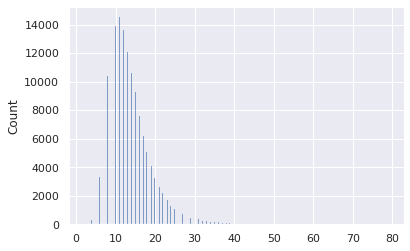


148915 captions in our dataset
Mean number of words in caption is: 13.390511365544102
Min number of words in caption is: 2
Max number of words in caption is: 79
Standard Deviation is: 5.4250111842269755



In [11]:
captions_length = []

for fname, cap in captions:
  w = len(word_tokenize(cap))
  captions_length.append(w)
    
sns.set(style="darkgrid")
sns
sns.histplot(data = captions_length)
plt.show()


print("""
{} captions in our dataset
Mean number of words in caption is: {}
Min number of words in caption is: {}
Max number of words in caption is: {}
Standard Deviation is: {}
""".format(len(captions_length), np.mean(captions_length), np.min(captions_length), np.max(captions_length), np.std(captions_length)))

In [12]:
#Αφαιρούμε σημεία στίξης

PUNCT_TOKENS = r"<>!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~"
def lencaption(caption):
  return len([word for word in caption.split(" ") if word not in PUNCT_TOKENS])

In [13]:
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

In [14]:
for i in captions:
  print(i,"\n")
  break

('_1000070808.jpg', 'A little girl holds orange lilies while others celebrate an occasion in a garden setting .') 



In [15]:
from collections import defaultdict
from csv import reader
caption_lengths = []

image_folder = str(path/IMAGE_DIR)

image_path_to_caption = defaultdict(list)
for row in captions:
  if (lencaption(row[-1]) <= 25 and lencaption(row[-1]) >= 7) : image_path_to_caption[f"{image_folder}/{row[0]}"].append(f"<start> {row[-1]} <end>")

In [17]:
train_captions = []
img_name_vector = []
image_paths = list(image_path_to_caption.keys())

for image_path in image_paths:
  train_captions.extend(image_path_to_caption[image_path])
  img_name_vector.extend([image_path] * len(image_path_to_caption[image_path]))

In [18]:
print(len(img_name_vector))
print(len(train_captions))

134153
134153


**Μετά την επεξεργασία ο συνολικός αριθμός από captions μειώθηκε κατά περίπου 15 χιλιαδες.**

## Split to test-train sets

In [19]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We override the default standardization to preserve "<>" characters and, by extension, <start> and <end> tokens.
tokenizer = tf.keras.layers.TextVectorization(
  max_tokens=VOCABULARY_SIZE,
  standardize=lambda inputs: tf.strings.regex_replace(tf.strings.lower(inputs), PUNCT_TOKENS[2:], ""),
  output_sequence_length=25
)

# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

# Store vocabulary list and its size
vocabulary=tokenizer.get_vocabulary()
VOCABULARY_SIZE = tokenizer.vocabulary_size()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [20]:
from random import shuffle

img_to_cap_vector = defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector): img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  img_name_train.extend([imgt] * len(img_to_cap_vector[imgt]))
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  img_name_val.extend([imgv] * len(img_to_cap_vector[imgv]))
  cap_val.extend(img_to_cap_vector[imgv])

In [21]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(107320, 107320, 26833, 26833)

['<start>', 'a', 'woman', 'in', 'a', 'white', 'dress', 'and', 'colorful', 'hat', 'is', 'dancing', 'and', 'singing', 'on', 'stage', 'in', 'front', 'of', 'a', 'band', '.', '<end>']


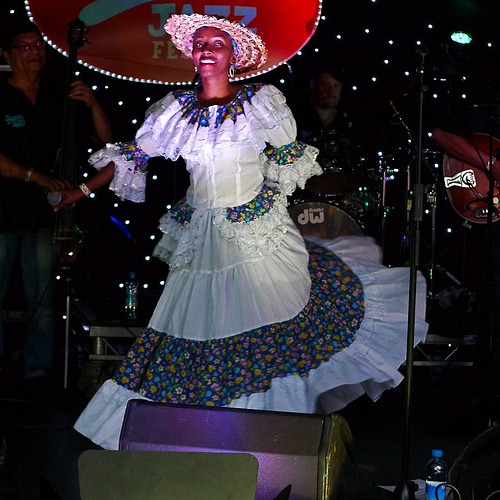

In [22]:
j=86
print([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[j] if i not in [0]])
Image.open(img_name_val[j])

## Image feature extractor

You will use an image model (pretrained on imagenet) to extract the features from each image. The model was trained as an image classifier, but setting `include_top=False` returns the model without the final classification layer, so you can use the last layer of feature-maps:  

**Στο παρόν notebook χρησιμοποιούμε το μοντέλο VGG16 το οποίο εμφάνισε τελικά βελτίωση από ότι το mobile μοντέλο που χρησιμοποιήθηκε για baseline.**

In [23]:
#The default input size for this model is 224x224.


IMAGE_SHAPE=(224, 224, 3)
model = tf.keras.applications.VGG16(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights='imagenet')
model.trainable=False

new_input = model.input
hidden_layer = model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58889256/58889256 [==============================] - 0s 0us/step


Here's a function to load an image and resize it for the model:

In [25]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    img = tf.keras.applications.vgg16.preprocess_input (img)
    return img, image_path

The model returns a feature map for each image in the input batch:

In [26]:
#img_name_vector was extended for each accepted caption, so we have the same image path multiple times
paths_for_feats = sorted(set(img_name_vector))

In [27]:
image_dataset = tf.data.Dataset.from_tensor_slices(paths_for_feats)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=16)

for img, path in tqdm.tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  
  attention_features_shape = batch_features.shape[1]
  features_shape = batch_features.shape[2]

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 1862/1862 [04:21<00:00,  7.11it/s]


## Embenddings

Στο παράδειγμα του tutorial τα embeddings μαθαίνονται κατά την εκπαίδευση του μοντέλου. Αντί αυτού θα δοκιμάσουμε τα έτοιμα embeddings του glove-wiki που κατεβάσαμε παραπάνω, αξιοποιώντας έτσι την τεχνική της μεταφορά μάθησης. Θα κάνουμε δοκιμές με διαφορετικά μεγέθη embeddings (100, 200, 300) και θα αξιολογήσουμε την απόδοση του μοντέλου.

In [28]:
import joblib
from gensim.downloader import load as gensim_download
import os
from os import path

pretrained_embeddings = {
  'glove-wiki-gigaword-100': 100,
  'glove-wiki-gigaword-200': 200,
  'glove-wiki-gigaword-300': 300
}
for e in pretrained_embeddings:
  if not path.exists(f'{e}.pkl'): joblib.dump(gensim_download(e), f'{e}.pkl')
  time.sleep(1)

glove_wiki = {e: joblib.load(f'{e}.pkl') for e in pretrained_embeddings}

[==============================================----] 93.5% 61.7/66.0MB downloaded
[=================================================-] 99.1% 249.7/252.1MB downloaded
[=================================================-] 99.2% 373.1/376.1MB downloaded


Υλοποιούμε μια συνάρτηση που δημιουργεί ένα πίνακα με embeddings τον οποίο θα χρησιμοποιήσουμε στη συνέχεια.

In [29]:
def buildEmbeddingMatrix(embedding):
  hits = 0
  misses = 0
  embedding_matrix = np.zeros((VOCABULARY_SIZE, pretrained_embeddings[embedding]))
  for i in range(VOCABULARY_SIZE):
    if vocabulary[i] in glove_wiki[embedding]:
      embedding_matrix[i] = glove_wiki[embedding][vocabulary[i]]
      hits += 1
    else:
      misses += 1
  return embedding_matrix

## Prepare the datasets

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 100
units = 256

In [31]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(
  lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]),
  num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Bahdanau Attention Mechanism

In [33]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units, dropout_rate):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)  
    self.dropout_rate = dropout_rate
    if dropout_rate: self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        
    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # Using dropout layer
    if self.dropout_rate: score = self.dropout(score)
        
    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
        
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
        
    return context_vector, attention_weights

In [34]:
class CNN_Encoder(tf.keras.Model):
  # Since you have already extracted the features and dumped it
  # This encoder passes those features through a Fully connected layer
  def __init__(self, embedding_dim, dropout_rate):
    super(CNN_Encoder, self).__init__()
    # shape after fc == (batch_size, 64, embedding_dim)
    self.fc = tf.keras.layers.Dense(embedding_dim)
    self.dropout_rate = dropout_rate
    if dropout_rate: self.dropout = tf.keras.layers.Dropout(dropout_rate)
  
  def call(self, x):
    x = self.fc(x)
    if self.dropout_rate: x = self.dropout(x)
    x = tf.nn.relu(x)
    return x

In [35]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size, embedding_matrix, dropout_rate, arch):
    super(RNN_Decoder, self).__init__()

    self.units = units

    if embedding_matrix.any():
      assert embedding_matrix.shape == (vocab_size, embedding_dim)
      self.embedding = tf.keras.layers.Embedding(
      input_dim=vocab_size, 
      output_dim=embedding_dim,
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
      trainable=False
      )
    else:
      self.embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim
      )

    self.arch = arch
    assert arch == 'GRU' or arch == 'LSTM'
    arch_args = dict(
      units=self.units,
      return_sequences=True,
      return_state=True,
      recurrent_initializer='glorot_uniform'
    )
    if arch == 'GRU': self.architecture = tf.keras.layers.GRU(**arch_args)
    if arch == 'LSTM': self.architecture = tf.keras.layers.LSTM(**arch_args)

    self.fc1 = tf.keras.layers.Dense(self.units)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units, dropout_rate)
  
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
        
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
        
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
    # passing the concatenated vector to the GRU/LSTM
    if self.arch == 'GRU': output, state = self.architecture(x)
    if self.arch == 'LSTM': output, state, _ = self.architecture(x)
        
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
        
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
        
    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)
    
    return x, state, attention_weights
        
  def reset_state(self, batch_size): return tf.zeros((batch_size, self.units))

In [36]:
MIN_CAPTION_LENGTH = 5
MAX_CAPTION_LENGTH = 50
MAX_VOCABULARY_SIZE = 5000
USED_DATA_PERCENTAGE = 100
EPOCHS = 25
CNN_DROPOUT = 0.5
RNN_DROPOUT = 0.5
RNN_ARCHITECTURE = 'LSTM'
#'GRU'
USE_BEAM_SEARCH = True
BEAM_SEARCH_WIDTH = 4 # This does not affect anything if USE_BEAM_SEARCH = False
USE_PRETRAINED_EMBEDDINGS = True
PRETRAINED_EMBEDDINGS = 'glove-wiki-gigaword-100' # This does not affect anything if USE_PRETRAINED_EMBEDDINGS = False

In [37]:
if USE_PRETRAINED_EMBEDDINGS:
  embedding_matrix = buildEmbeddingMatrix(PRETRAINED_EMBEDDINGS)
  EMBEDDING_DIMENSION = pretrained_embeddings[PRETRAINED_EMBEDDINGS]
else:
  embedding_matrix = np.array(None)
  EMBEDDING_DIMENSION = embedding_dim

cnn_args = dict(
  embedding_dim=EMBEDDING_DIMENSION,
  dropout_rate=CNN_DROPOUT
)

rnn_args = dict(
  embedding_dim=EMBEDDING_DIMENSION,
  units=units,
  vocab_size=VOCABULARY_SIZE,
  embedding_matrix=embedding_matrix,
  dropout_rate=RNN_DROPOUT,
  arch=RNN_ARCHITECTURE
)

encoder = CNN_Encoder(**cnn_args)
decoder = RNN_Decoder(**rnn_args)

In [38]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [39]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [40]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [41]:
# adding this in a separate cell, because if you run the training cell many times, the loss_plot array will be reset
loss_plot = []

In [42]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
    
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
      # passing the features through the decoder
      predictions, hidden, _ = decoder(dec_input, features, hidden)
      loss += loss_function(target[:, i], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

In [43]:
for epoch in range(start_epoch, EPOCHS):
  start = time.time()
  total_loss = 0

  for (batch, (img_tensor, target)) in enumerate(dataset):
    batch_loss, t_loss = train_step(img_tensor, target)
    total_loss += t_loss

    if batch % 100 == 0:
      average_batch_loss = batch_loss.numpy()/int(target.shape[1])
      print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

  # storing the epoch end loss value to plot later
  loss_plot.append(total_loss / num_steps)
  
  if epoch % 5 == 0: ckpt_manager.save()

  print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 4.8485
Epoch 1 Batch 100 Loss 3.1918
Epoch 1 Batch 200 Loss 2.9686
Epoch 1 Batch 300 Loss 2.4176
Epoch 1 Batch 400 Loss 2.0497
Epoch 1 Batch 500 Loss 2.1627
Epoch 1 Batch 600 Loss 2.3245
Epoch 1 Batch 700 Loss 1.9595
Epoch 1 Batch 800 Loss 2.1256
Epoch 1 Batch 900 Loss 2.0217
Epoch 1 Batch 1000 Loss 2.0853
Epoch 1 Batch 1100 Loss 1.9193
Epoch 1 Batch 1200 Loss 1.9398
Epoch 1 Batch 1300 Loss 1.9424
Epoch 1 Batch 1400 Loss 1.8865
Epoch 1 Batch 1500 Loss 2.1310
Epoch 1 Batch 1600 Loss 1.9124
Epoch 1 Loss 2.217277
Time taken for 1 epoch 208.40 sec

Epoch 2 Batch 0 Loss 2.0121
Epoch 2 Batch 100 Loss 2.1265
Epoch 2 Batch 200 Loss 1.7302
Epoch 2 Batch 300 Loss 1.9094
Epoch 2 Batch 400 Loss 1.7034
Epoch 2 Batch 500 Loss 1.6373
Epoch 2 Batch 600 Loss 1.9959
Epoch 2 Batch 700 Loss 1.9458
Epoch 2 Batch 800 Loss 1.7866
Epoch 2 Batch 900 Loss 1.9517
Epoch 2 Batch 1000 Loss 1.8362
Epoch 2 Batch 1100 Loss 1.8868
Epoch 2 Batch 1200 Loss 1.9332
Epoch 2 Batch 1300 Loss 1.8543
Epoch 

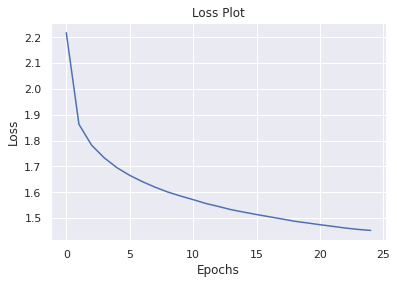

In [44]:
#VGG16 - 100 emd
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## BeamSearch

In [46]:
class BeamSearchState:
  def __init__(self, words, hidden, probability, features, width):
    self.words = words
    self.hidden = hidden
    self.probability = probability
    self.features = features
    self.width = width

  def nextStates(self):
    last_word = self.words[-1]
    if last_word == '<end>': return [self]

    predictions, hidden, _ = decoder(
      tf.expand_dims([word_to_index(last_word)], 0),
      self.features,
      self.hidden
    )
    candidates = np.argsort(tf.nn.softmax(predictions[0]))[::-1][:self.width]

    return [
      BeamSearchState(
        self.words + [tf.compat.as_text(index_to_word(i).numpy())],
        hidden,
        self.probability * tf.nn.softmax(predictions[0])[i].numpy(),
        self.features,
        self.width
      )
      for i in candidates
    ]

def beamSearchEvaluate(image, width):
  hidden = decoder.reset_state(batch_size=1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  result = ['<start>']
  initialStates = BeamSearchState(result, hidden, 1, features, width).nextStates()

  # Filling currentStates with b^2 states for the first time
  currentStates = []
  for state in initialStates: currentStates.extend(state.nextStates())

  for i in range(MAX_CAPTION_LENGTH - 2):
    #for s in currentStates: print(s.words)
    state2probability = {state: state.probability for state in currentStates}
    sortedState2probability = {k: v for k, v in sorted(state2probability.items(), key=lambda item: item[1])}
    sortedStates = list(sortedState2probability.keys())[::-1]

    # finding best b states among b^2
    initialStates = sortedStates[:width]
    
    # Filling currentStates with b^2 states again
    currentStates = []
    for state in initialStates: currentStates.extend(state.nextStates())

  return currentStates[0].words[1:]

def beamSearchAttentionPlot(image, result):
  attention_plot = np.zeros((MAX_CAPTION_LENGTH, attention_features_shape))
  hidden = decoder.reset_state(batch_size=1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([word_to_index('<start>')], 0)

  for i in range(len(result)):
    _, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    dec_input = tf.expand_dims([word_to_index(result[i])], 0)

  return attention_plot[:len(result), :]

In [47]:
def evaluate(image, beam_search, width):
  if beam_search:
    result = beamSearchEvaluate(image, width)
    attention_plot = beamSearchAttentionPlot(image, result)
    return result, attention_plot

In [48]:
def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))
  fig = plt.figure(figsize=(25, 25))
  
  for i in range(len(result)):
    temp_att = np.resize(attention_plot[i], (8, 8))
    grid_size = max(int(np.ceil(len(result)/2)), 2)
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.set_title(result[i])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

## **Στη συνέχεια παρουσιάζουμε μερικά captions που παράγει το εκπαιδευμένο μοντέλο μας στο validation set**

### Κάποια μη ικανοποιητικά captions:

Real Caption: <start> in this photo , a [UNK] is singing in front of a crowd . <end>
Prediction Caption: a group of people are sitting at a restaurant . <end>


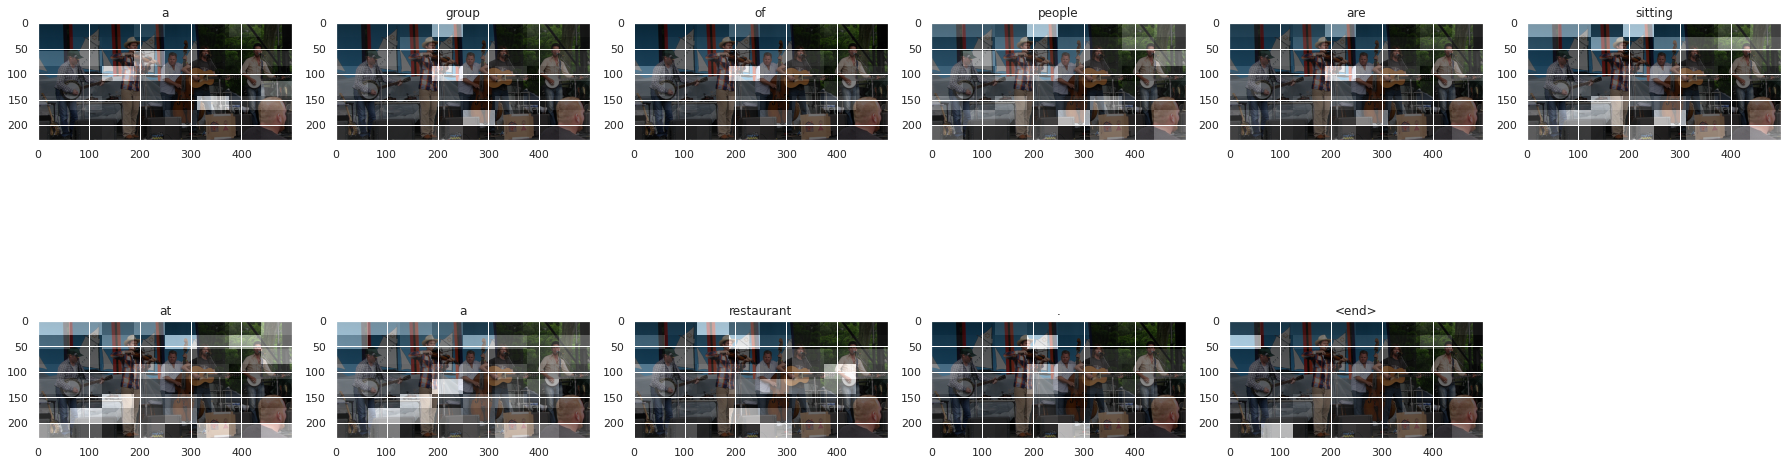

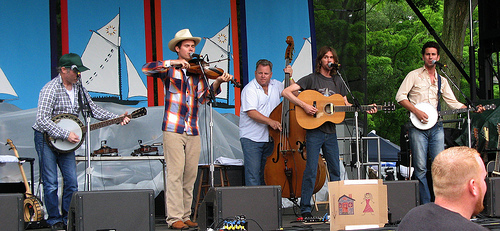

In [49]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid+60]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid+60] if i not in [0]])

result, attention_plot = evaluate(image, beam_search=USE_BEAM_SEARCH, width=BEAM_SEARCH_WIDTH)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

**Ενώ το μοντέλο κατάφερε να εντοπίσει ότι πρόκειται για ένα "group of people" δεν πετυχαίνει να κάνει caption ούτε το background (μουσική σκηνή), ούτε την δραστηριότητα.**

Real Caption: <start> a man sleeping on a bench with a guitar set next to him . <end>
Prediction Caption: workers working on a street . <end>


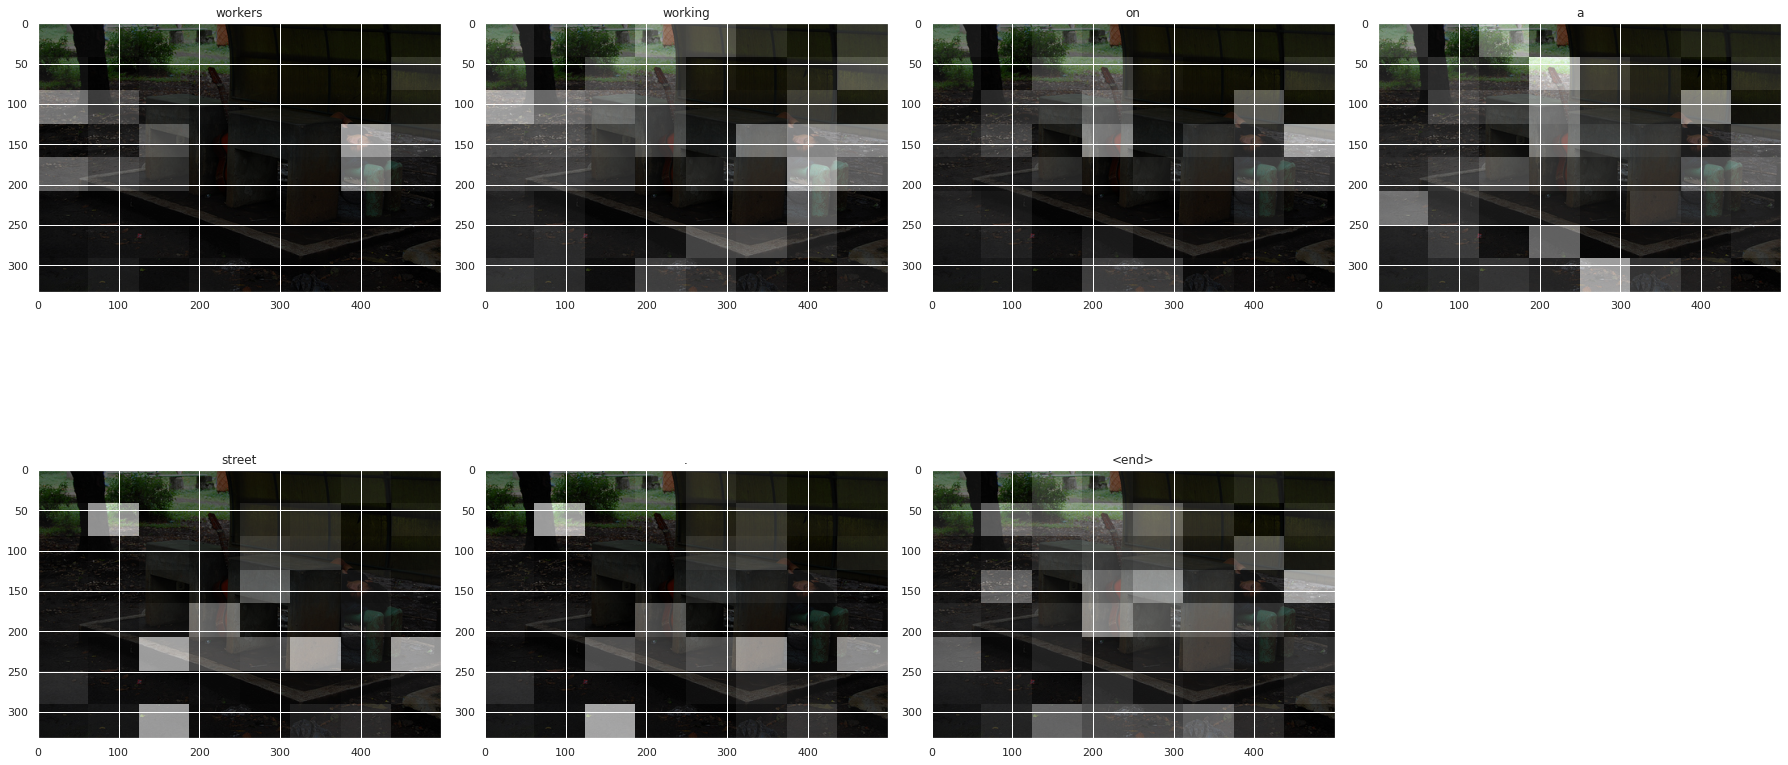

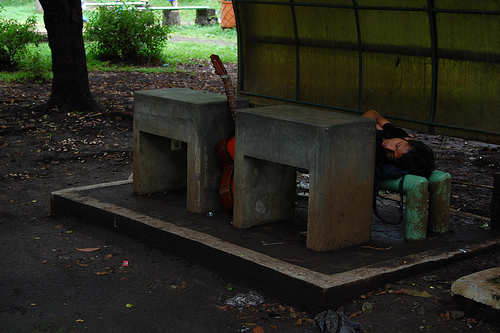

In [65]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid+60]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid+60] if i not in [0]])

result, attention_plot = evaluate(image, beam_search=USE_BEAM_SEARCH, width=BEAM_SEARCH_WIDTH)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

**Το συγκεκριμένο caption είναι πολύ αποτυχημένο καθώς δεν πιάνει καθόλου το νόημα της φωτογραφίας.**

Real Caption: <start> photographer shooting pictures of a old sign . <end>
Prediction Caption: a man with a cigarette . <end>


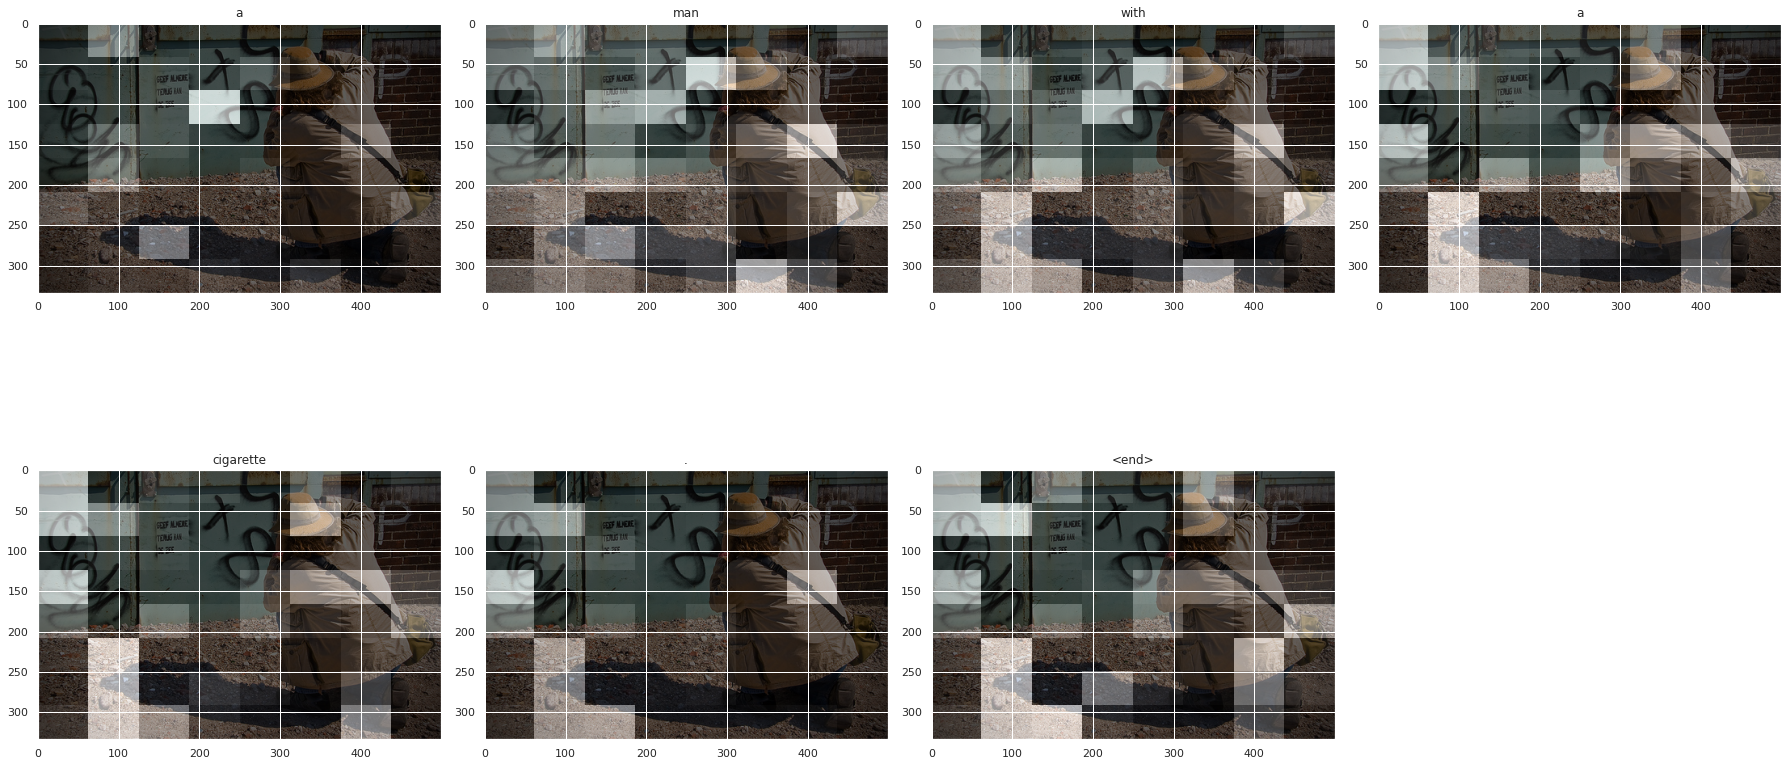

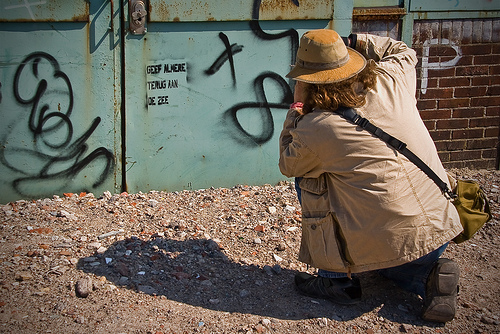

In [66]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid+60]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid+60] if i not in [0]])

result, attention_plot = evaluate(image, beam_search=USE_BEAM_SEARCH, width=BEAM_SEARCH_WIDTH)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

**Και σε αυτή την περίπτωση πέρα από τον εντοπισμό της κεντρικής φιγούρας ("a man") το caption δεν είναι ικανοποιητικό.**

### Επιτυχημένα captions:
**Και στις 3 περιπτώσεις βέβαια υπάρχουν αστοχίες αλλά σε γενικές γραμμές τις κρίνουμε πετυχημένες**

Real Caption: <start> a large dog chases a boy through a field . <end>
Prediction Caption: a little girl in a red and white dog jumping in the grass . <end>


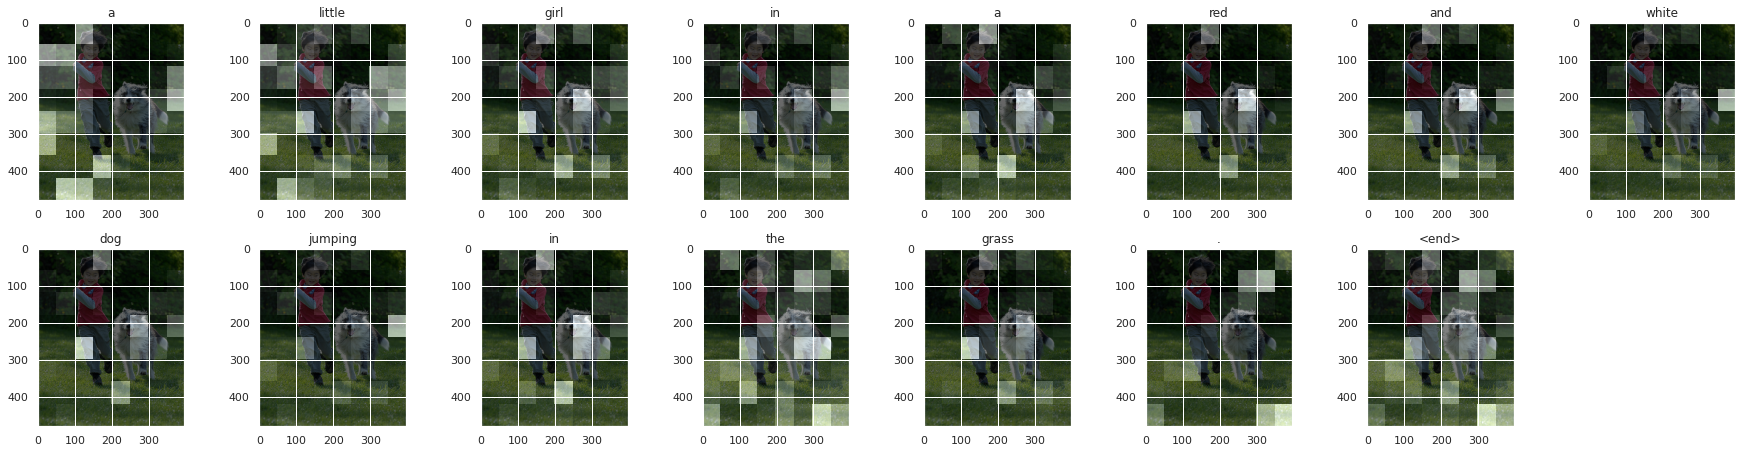

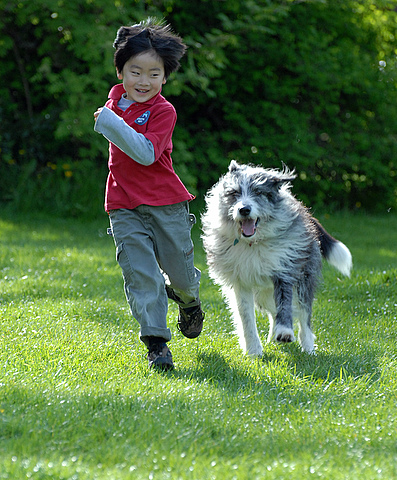

In [69]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid+60]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid+60] if i not in [0]])

result, attention_plot = evaluate(image, beam_search=USE_BEAM_SEARCH, width=BEAM_SEARCH_WIDTH)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

Real Caption: <start> a bmx biker performs stunts on a hilly track . <end>
Prediction Caption: a man on a bike . <end>


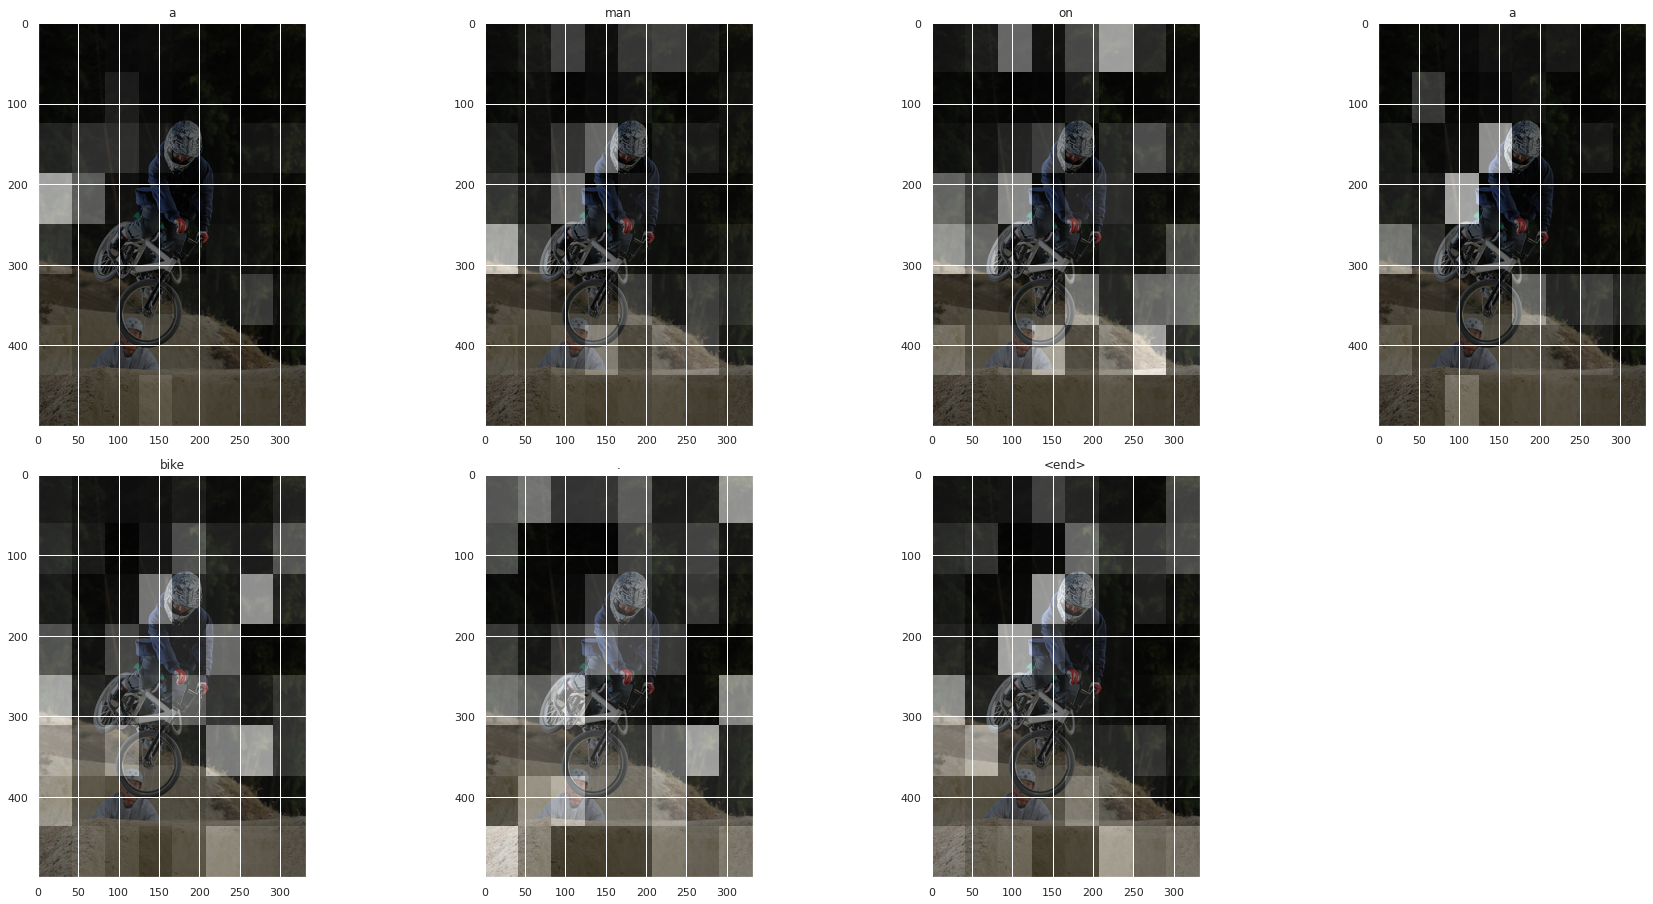

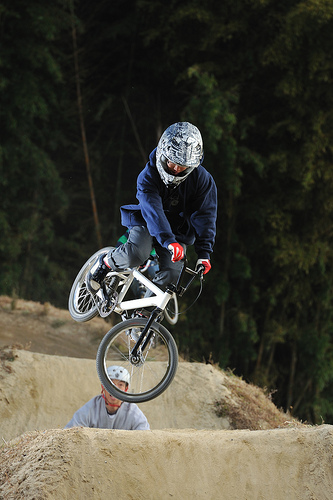

In [72]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid+60]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid+60] if i not in [0]])

result, attention_plot = evaluate(image, beam_search=USE_BEAM_SEARCH, width=BEAM_SEARCH_WIDTH)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

Real Caption: <start> a man on a lift is inspecting a tree . <end>
Prediction Caption: a man in a white shirt is walking past a palm tree . <end>


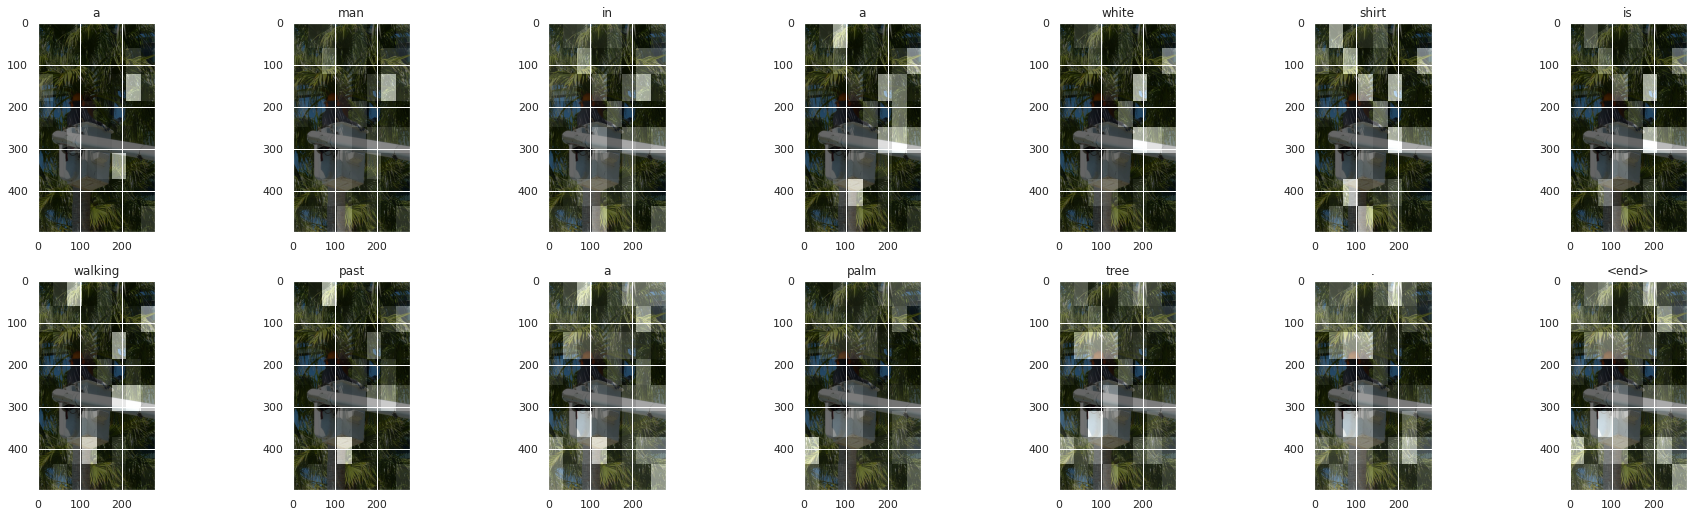

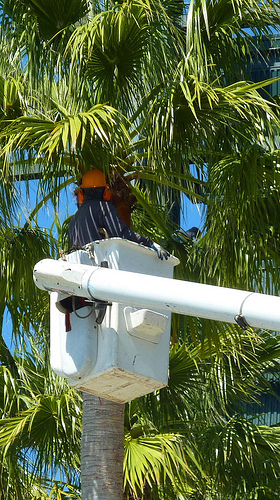

In [73]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid+60]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid+60] if i not in [0]])

result, attention_plot = evaluate(image, beam_search=USE_BEAM_SEARCH, width=BEAM_SEARCH_WIDTH)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

## BLEU

Η αξιολόγηση των captions θα γίνει με την χρήση του BLUE score. Το BLEU είναι ένας σταθμισμένος μέσος όρος του πλήθους των κοινών unigrams, bigrams, trigrams, και fourgrams μεταξύ hypothesis και references. Το χειρότερο captioning λαμβάνει 0 και το καλύτερο 1.

In [53]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

def removeBorderTokens(word_list):
  "Remove <start>, <end> tokens from a word list."
  if word_list[0] == '<start>': word_list = word_list[1:]
  if word_list[-1] == '<end>': word_list = word_list[:-1]
  return word_list

def removePunctuationTokens(word_list):
  "Remove punctuation tokens from a word list."
  return [word for word in word_list if word not in PUNCT_TOKENS]

def buildReference(rid):
  return ' '.join(
    removePunctuationTokens(
      removeBorderTokens(
        [tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]]
      )
    )
  )

def buildHypothesis(rid):
  return ' '.join(
    removePunctuationTokens(
      removeBorderTokens(
        evaluate(
          image=img_name_val[rid],
          beam_search=USE_BEAM_SEARCH,
          width=BEAM_SEARCH_WIDTH
        )[0]
      )
    )
  )

def getSentenceBleu(rid):
  low = rid
  high = rid
  while low > 0 and img_name_val[low-1] == img_name_val[rid]:
    low -= 1
  while high < len(img_name_val) - 1 and img_name_val[high+1] == img_name_val[rid]:
    high += 1
  hypothesis = buildHypothesis(rid)
  print("Hypothesis:", hypothesis)
  return sentence_bleu(
    references=[buildReference(i) for i in range(low, high + 1)],
    hypothesis=hypothesis,
    weights=(0.4, 0.3, 0.2, 0.1),
    smoothing_function=SmoothingFunction().method1
  )

def getCorpusBleu():
  corpus = {}
  for rid in tqdm.tqdm(range(len(img_name_val)-24833)):
    if img_name_val[rid] not in corpus:
      corpus[img_name_val[rid]] = dict(hypothesis=buildHypothesis(rid), references=[])
    corpus[img_name_val[rid]]["references"].append(buildReference(rid))
  return corpus_bleu(
    list_of_references=[corpus[img]["references"] for img in corpus],
    hypotheses=[corpus[img]["hypothesis"] for img in corpus],
    weights=(0.4, 0.3, 0.2, 0.1),
    smoothing_function=SmoothingFunction().method1
  )

In [57]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, beam_search=USE_BEAM_SEARCH, width=BEAM_SEARCH_WIDTH)

print('Real Caption:', real_caption)
print(getSentenceBleu(rid))

Real Caption: <start> a young man sits with his [UNK] on his legs while he reads a book . <end>
Hypothesis: a man in a blue shirt
0.56274949183507


In [63]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, beam_search=USE_BEAM_SEARCH, width=BEAM_SEARCH_WIDTH)

print('Real Caption:', real_caption)
print(getSentenceBleu(rid))

Real Caption: <start> two dogs are playing in a grassy field . <end>
Hypothesis: two dogs are playing in the grass
0.8512582235479137


In [64]:
print(getCorpusBleu())

100%|██████████| 2000/2000 [29:52<00:00,  1.12it/s]


0.5630120570293936


# Τελικά συμπεράσματα - Αποτελέσματα

Αρχικά, σε όλα τα πειράματα χρησιμοποιήσαμε:
- μέγεθος λεξιλογίου ίσο με 5000
- sentence generation με Beam Search με width=4
- LSTM αρχιτεκτονική για τον RNN decoder

Σχετικά με την επιλογή Encoder δοκιμάσαμε μια πληθώρα μοντέλων, ξεκινώντας βέβαια από το MobileNetV3Small. Για dropout = 0.5, 512 units και glove-wiki-gigaword-100 για embedding πήραμε **Bleu score = 0.5436**.
Στη συνέχεια αλλάζοντας τον αριθμό των units σε 256 και χρησιμοποιώντας τον encoder VGG16 είχαμε **Bleu score = 0.5630**, οπότε και αποφασίσαμε να συνέχισουμε τα πειράματα με τον συγκεκριμένο encoder.

Κάποιοι άλλοι encoders τους οποίους δοκιμάσαμε χωρίς αποτέλεσμα ήταν οι:
- ResNet50, ο οποίος εμφάνισε καλή χρήση της RAM, αλλά είχε σχετικά αργό extraction και πολύ κακούς χρόνους στο training του μοντέλου προσοχής
- NesNet, με παρόμοια συμπεριφορά
- Xception, ο οποίος με διάφορους μεγέθη batch κατέληγε πάντα να εξαντλεί τη RAM πολύ νωρίς κατά την διάρκεια του training.
- EfficientNetB0, ομοίως για χρήση RAM. Βέβαια ήταν με διαφορά ο πιο γρήγορος encoder από όσους δοκιμάσαμε, αλλά δεν προχώρησε σε επόμενα πειράματα.

Τα αποτελέσματα που βρήκαμε χρησιμοποιώντας τον encoder VGG16 σε μέγεθος CorpusBleu 2000, με την πρώτη γραμμή να έχει το καλύτερο αποτέλεσμα είναι τα εξής: 

| Number of Units | Embedding dimension | dropout | Bleu Score |
|-----------------|---------------------|---------|------------|
| 256             | 100                 | 0.5     | **0.563**  |
| 512             | 300                 | 0.5     | 0.519      |
| 256             | 100                 | 0.7     | 0.510      |
| 256             | 100                 | 0.3     | 0.541      |
| 128             | 100                 | 0.6     | 0.501      |   